In [1]:
import sys
sys.path.append('./rllab')
sys.path.append('./rltools')

# from __future__ import print_function
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

from madrl_environments.cas.multi_aircraft import *

import matplotlib.pyplot as plt

import joblib
import tensorflow as tf
import numpy as np

In [2]:
import math

In [3]:
XMIN = -1200
XMAX = 1200
YMIN = XMIN
YMAX = XMAX

In [4]:
def vis_slice(env,
              policy,
              resolution=100,
              own_v=20, 
              own_heading=0,
              own_turn_rate=0,
              own_dest_x=4000,
              own_dest_y=0,
              int_heading=np.deg2rad(180), 
              int_v=15):
    
    # ownship setup
    env.aircraft[0].x = 0
    env.aircraft[0].y = 0
    env.aircraft[0].dest_x = own_dest_x
    env.aircraft[0].dest_y = own_dest_y
    env.aircraft[0].heading = own_heading
    env.aircraft[0].dist_to_dest = np.sqrt((env.aircraft[0].dest_y)**2 + (env.aircraft[0].dest_x)**2)
    env.aircraft[0].init_dist_to_dest = env.aircraft[0].dist_to_dest * 2
    env.aircraft[0].prev_dist_to_dest = env.aircraft[0].dist_to_dest + own_v
    env.aircraft[0].v = own_v
    env.aircraft[0].turn_rate = own_turn_rate
    
    def get_heat(x, y):
        # intruder setup
        env.aircraft[1].x = x
        env.aircraft[1].y = y
        intruder_pos_angle = math.atan2(y - env.aircraft[0].y, x - env.aircraft[0].x)
        env.aircraft[1].heading = int_heading
        env.aircraft[1].v = int_v
        # ownship:
        # print('int_x = {}, int_y = {}, intruder_pos_angle = {}'.format(x, y, norm_angle(intruder_pos_angle - env.aircraft[0].heading) / pi))
        obs = env.aircraft[0].get_observation()
        action, action_info = policy.get_action(obs)
        return action, action_info

    acc_map = np.zeros((resolution, resolution))
    turn_rate_map = np.zeros((resolution, resolution))
    x_arr = np.linspace(XMIN, XMAX, resolution)
    y_arr = np.linspace(YMIN, YMAX, resolution)

    # print(get_heat(400, 400))

    for j in range(resolution):
        for i in range(resolution):
            actions = get_heat(x_arr[i], y_arr[j])[1]['mean']
            acc_map[j][i] = actions[ACTION_IND_ACC]
            turn_rate_map[j][i] = actions[ACTION_IND_TURN]
#             print('acc = {}, tr = {}'.format(acc_map[j][i], turn_rate_map[j][i]))

    acc_map = np.flipud(acc_map)
    turn_rate_map = np.flipud(turn_rate_map)

    plt.figure()
    plt.imshow(acc_map, cmap="jet", extent=(XMIN, XMAX, YMIN, YMAX))
    plt.colorbar(label='acc')
    plt.figure()
    plt.imshow(turn_rate_map, cmap="jet", extent=(XMIN, XMAX, YMIN, YMAX))
    plt.colorbar(label='turn_rate')
    plt.ion()


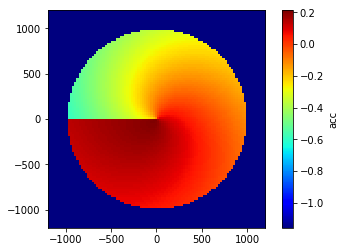

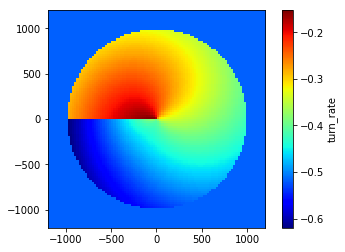

In [6]:
data_file_path = './rllab/data/test/itr_299.pkl'
tf.reset_default_graph()
with tf.Session() as sess:
    data = joblib.load(data_file_path)
    policy = data['policy']
    
    env = MultiAircraftEnv()
    env.reset()
    env.aircraft = []
    env.aircraft.append(Aircraft(env))
    env.aircraft.append(Aircraft(env))
    env.speed_noise = 1e-12
    env.angle_noise = 1e-12
    env.position_noise = 1e-12
    
    vis_slice(env, policy, 
              resolution=100,
              own_v=40, 
              own_heading=0,
              own_turn_rate=0,
              own_dest_x=5000,
              own_dest_y=0,
              int_heading=np.deg2rad(90), 
              int_v=40)